In [27]:
from tensorboard.backend.event_processing import event_accumulator
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import re, numpy as np          # only needed for a quick regex filter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path
from tensorboard.backend.event_processing import event_accumulator
import json, platform
from datetime import datetime

In [28]:
pt_to_in = lambda pt: pt / 72

In [29]:

circuit = "0xF4E7"
#Fine-tuning better versus new: 0x0F42, 0x1048, 0x10C9
# experiments
run_dirs = {
    "Pre-trained fine-tune": Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/4_inputs/50_000_steps/{circuit}/seed_1"),
    "Scratch":               Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/scratch_training/4in/{circuit}/seed_1"),
                                    
}

colors = {
    "Pre-trained fine-tune": "#FF914D",
    "Scratch":               "#417FF1",
}


In [30]:
#Curious about 0x2B fine-tuning in network trained on 4 inputs 
'''
circuit = "0x2B"
#Fine-tuning better versus new: 0x0F42, 0x1048, 0x10C9
# experiments
run_dirs = {
    "Pre-trained fine-tune": Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/fine_tune/{circuit}/seed_1"),
    "Scratch":               Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/{circuit}/seed_1"),
                                    
}

colors = {
    "Pre-trained fine-tune": "#FF914D",
    "Scratch":               "#417FF1",
}
'''


'\ncircuit = "0x2B"\n#Fine-tuning better versus new: 0x0F42, 0x1048, 0x10C9\n# experiments\nrun_dirs = {\n    "Pre-trained fine-tune": Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/fine_tune/{circuit}/seed_1"),\n    "Scratch":               Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/{circuit}/seed_1"),\n                                    \n}\n\ncolors = {\n    "Pre-trained fine-tune": "#FF914D",\n    "Scratch":               "#417FF1",\n}\n'

In [31]:
save_path = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/fine_tune/representative_plots/{circuit}"

In [32]:
#Fine-tuning better versus old: 0x0643, 0x0F42, 0x10C9

'''
# experiments
circuit = "0x0643"

run_dirs = {
    "Pre-trained fine-tune": Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/4_inputs/50_000_steps/{circuit}/seed_1"),
    "Scratch":               Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_{circuit}/seed_1"),
                                    
}

colors = {
    "Pre-trained fine-tune": "#FF914D",
    "Scratch":               "#417FF1",
}
'''

'\n# experiments\ncircuit = "0x0643"\n\nrun_dirs = {\n    "Pre-trained fine-tune": Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/4_inputs/50_000_steps/{circuit}/seed_1"),\n    "Scratch":               Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_{circuit}/seed_1"),\n                                    \n}\n\ncolors = {\n    "Pre-trained fine-tune": "#FF914D",\n    "Scratch":               "#417FF1",\n}\n'

DirectoryDeletedError: Directory /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/4_inputs/50_000_steps/0xF4E7/seed_1 has been permanently deleted

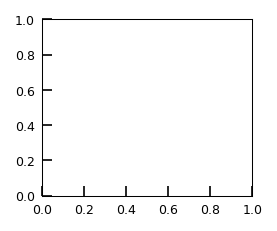

In [33]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pathlib import Path
import matplotlib.ticker as ticker

# ── GraphPad-ish style ────────────────────────────────────────────────────────
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False
})


# ── exponential moving average  (weight≈0.9 → strong smoothing) ──────────────
def smooth(vals, weight=0.0):
    out, last = [], vals[0] if len(vals) else 0
    for v in vals:
        last = last * weight + (1 - weight) * v
        out.append(last)
    return np.asarray(out)

# ── helper to pull one run from disk ──────────────────────────────────────────
def load_curve(run_dir, tag="custom/best_energy", zero_at_start=True):
    ea = event_accumulator.EventAccumulator(str(run_dir))
    ea.Reload()

    events = ea.Scalars(tag)
    steps  = np.fromiter((e.step  for e in events), dtype=int)
    values = np.fromiter((e.value for e in events), dtype=float)

    if zero_at_start and len(steps) and steps[0] != 0:
        steps -= steps[0]                         # set first point to x = 0
    return steps, values


# ── plot both traces ──────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)

for label, path in run_dirs.items():
    steps, vals = load_curve(path)        # <─ pull the data for THIS run
    if len(steps) == 0:                   # optional safety check
        print(f"[warn] no data found for {label} in {path}")
        continue
    ax.plot(steps,
            smooth(vals, weight=0),       # weight>0 → smoothing; 0 → raw
            label=label,
            color=colors[label])

# ── more ticks ───────────────────────────────────────────────────────────────
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))      # major every 5
#ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())      # 4 minors by default
#ax.tick_params(axis="x", which="minor", length=4)          # thinner minor ticks

#ax.set_yscale("log", base = 2)
ax.set_yscale("log")
#ax.yaxis.set_major_locator(ticker.LogLocator(base=10))      # 1,10,100…
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

# Major ticks every 1 unit
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Minor ticks every 0.5 units
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))


# … rest of your formatting …
ax.set_xlim(left=-1, right=50000)
#ax.set_ylim(5, 30)
ax.xaxis.set_major_locator(mticker.MultipleLocator(25_000))
ax.tick_params(axis="both", which="both", direction="out", length=2, width=0.5)
ax.set_xlabel("Training steps")
ax.set_ylabel("Circuit size")
ax.legend()
plt.tight_layout()
plt.show()
print(vals[-1])


In [ ]:
steps[8]

640

In [ ]:
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
    "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
    "pdf.use14corefonts": False,  # allow embedding non-core fonts
    "svg.fonttype": "none",       # keep SVG text as text (not paths)
    
})


Reward

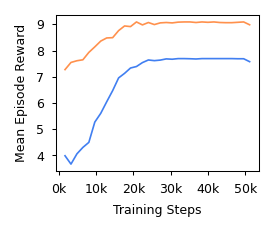

In [ ]:
SMOOTHING_WEIGHT = 0          # 0 → no smoothing

# ── helpers ────────────────────────────────────────────────────────────────


def smooth(arr, weight=0.0):
    """Simple exponential smoothing (0 ≤ weight < 1)."""
    if weight <= 0:
        return arr
    out = np.empty_like(arr, dtype=float)
    out[0] = arr[0]
    for i in range(1, len(arr)):
        out[i] = weight * out[i - 1] + (1 - weight) * arr[i]
    return out

# ── plotting ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)

for label, event_dir in run_dirs.items():
    event_dir = Path(event_dir)
    if not event_dir.exists():
        print(f"{event_dir} not found – skipping")
        continue

    ea = event_accumulator.EventAccumulator(str(event_dir))   # ensure str path
    ea.Reload()

    reward_events = ea.Scalars("rollout/ep_rew_mean")
    if not reward_events:
        print(f"No 'rollout/ep_rew_mean' in {event_dir} – skipping")
        continue

    steps  = np.asarray([e.step  for e in reward_events], dtype=float)
    values = np.asarray([e.value for e in reward_events], dtype=float)

    # Smooth the reward directly
    smoothed_values = smooth(values, weight=SMOOTHING_WEIGHT)

    ax.plot(
        steps,
        smoothed_values,
        label=label,
        color=colors.get(label, None),
        linewidth=0.8,
    )

# styling
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

ax.xaxis.set_major_locator(mticker.MultipleLocator(10_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))

ax.tick_params(axis="both", which="both", direction="out", length=2, width=0.5)
ax.set_xlabel("Training Steps")
ax.set_ylabel(r"Mean Episode Reward")
#ax.set_xlim(left=0, right=10_000)
#ax.legend(loc="best", frameon=False)
plt.tight_layout()
#plt.show()


In [ ]:
out = Path(save_path) / f"reward_{circuit}_finetuning_vs_scratch.svg"
out.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out, bbox_inches="tight")  

In [ ]:
metadata = {
    "circuit": circuit,
    "smoothing_weight": float(SMOOTHING_WEIGHT) if "SMOOTHING_WEIGHT" in globals() else None,
    "run_dirs": {k: str(v) for k, v in run_dirs.items()},   # derived copy
    "colors": dict(colors),
    "timestamp_iso": datetime.now().isoformat(timespec="seconds"),
    "env": {
        "python": platform.python_version(),
        "platform": platform.platform(),
        "matplotlib": mpl.__version__,
        "numpy": np.__version__,
        "tensorboard": getattr(__import__("tensorboard"), "__version__", None),
    },
    "plot": {
        "xlabel": "Training Steps",
        "ylabel": "Mean Episode Reward",
        "figure_size_inches": list(fig.get_size_inches()) if "fig" in globals() else None,
        "dpi": fig.dpi if "fig" in globals() else None,
    },
}

# Save sidecar JSON
with open(out.with_suffix(".json"), "w") as f:
    json.dump(metadata, f, indent=2)

Harmonic mean

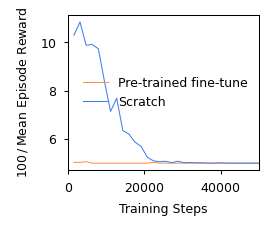

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path
from tensorboard.backend.event_processing import event_accumulator

SMOOTHING_WEIGHT = 0          # 0 → no smoothing

# ── helpers ────────────────────────────────────────────────────────────────
pt_to_in = lambda pt: pt / 72

def smooth(arr, weight=0.0):
    """Simple exponential smoothing (0 ≤ weight < 1)."""
    if weight <= 0:
        return arr
    out = np.empty_like(arr)
    out[0] = arr[0]
    for i in range(1, len(arr)):
        out[i] = weight * out[i - 1] + (1 - weight) * arr[i]
    return out

# ── plotting ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)

for label, event_dir in run_dirs.items():
    if not event_dir.exists():
        print(f" {event_dir} not found – skipping")
        continue

    ea = event_accumulator.EventAccumulator(str(event_dir))   # ensure str path
    ea.Reload()

    reward_events = ea.Scalars("rollout/ep_rew_mean")
    steps  = np.asarray([e.step  for e in reward_events], dtype=float)
    values = np.asarray([e.value for e in reward_events], dtype=float)

    # avoid division by zero
    EPS = 1e-9
    inv_values = 100.0 / np.where(values != 0, values, EPS)
    smoothed_inv = smooth(inv_values, weight=SMOOTHING_WEIGHT)

    ax.plot(
        steps,
        smoothed_inv,
        label=label,
        color=colors[label],
        linewidth=0.5,
    )

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

ax.xaxis.set_major_locator(mticker.MultipleLocator(20_000))
ax.tick_params(axis="both", which="both", direction="out", length=2, width=0.5)
ax.set_xlabel("Training Steps")
ax.set_ylabel(r"$100 \,/\, \mathrm{Mean\ Episode\ Reward}$")
ax.set_xlim(left=0, right=50_000)
ax.legend(loc="best")
plt.tight_layout()

Zero-shot

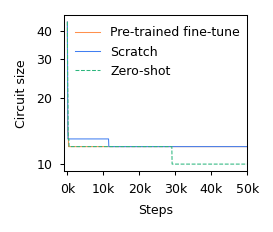

In [ ]:
circuit = "0x4724"

run_dirs = {
    "Pre-trained fine-tune": Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/4_inputs/50_000_steps/{circuit}/seed_1"),
    "Scratch":               Path(f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/scratch_training/4in/{circuit}/seed_1"),
}

track1_files = {
    "Zero-shot": Path(
        f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/zero-shot/mp/5120_episodes/sf4/{circuit}/seed_1/trained_masked/tb_compat_steps.csv"
    )
}

colors = {
    "Pre-trained fine-tune": "#FF914D",
    "Scratch":               "#417FF1",
    "Zero-shot":   "#2CB67D",
}

from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pathlib import Path
import matplotlib.ticker as ticker

# (if you used 'mticker' earlier, you can just use 'ticker' everywhere)
# import matplotlib.ticker as mticker  # not needed; use 'ticker' alias above

# ── GraphPad-ish style (unchanged) ───────────────────────────────────────────
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False
})

# ── smoothing (unchanged) ────────────────────────────────────────────────────
def smooth(vals, weight=0.0):
    out, last = [], vals[0] if len(vals) else 0
    for v in vals:
        last = last * weight + (1 - weight) * v
        out.append(last)
    return np.asarray(out)

# ── helper: load TB scalar from a run dir (unchanged) ────────────────────────
def load_curve(run_dir, tag="custom/best_energy", zero_at_start=True):
    ea = event_accumulator.EventAccumulator(str(run_dir))
    ea.Reload()
    events = ea.Scalars(tag)
    steps  = np.fromiter((e.step  for e in events), dtype=int)
    values = np.fromiter((e.value for e in events), dtype=float)
    if zero_at_start and len(steps) and steps[0] != 0:
        steps -= steps[0]   # set first point to x = 0
    return steps, values

# ── NEW: helper to load Track 1 CSV ──────────────────────────────────────────
def load_track1_csv(csv_path: Path, use_wall_time=False, zero_at_start=True):
    """
    csv has columns: Step,custom/best_energy,wall_time_s
    choose x = Step (SB3-compatible total transitions) or x = wall_time_s
    """
    if not csv_path.exists():
        print(f"[warn] Track 1 CSV not found: {csv_path}")
        return np.array([]), np.array([])

    xs, ys = [], []
    with csv_path.open("r") as f:
        header = f.readline().strip().split(",")
        # expected: ["Step", "custom/best_energy", "wall_time_s"]
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 3:
                continue
            step_str, best_str, wt_str = parts[0], parts[1], parts[2]
            # pick x
            if use_wall_time:
                try:
                    x = float(wt_str) if wt_str != "" else None
                except ValueError:
                    x = None
            else:
                try:
                    x = int(step_str)
                except ValueError:
                    x = None
            # y = best energy
            try:
                y = float(best_str) if best_str != "" else None
            except ValueError:
                y = None

            if x is not None and y is not None:
                xs.append(x); ys.append(y)

    xs = np.asarray(xs, dtype=float if use_wall_time else int)
    ys = np.asarray(ys, dtype=float)

    # optional zero-at-start normalization for x-axis
    if zero_at_start and len(xs):
        xs = xs - xs[0]
    return xs, ys

# ── plot ─────────────────────────────────────────────────────────────────────
# If you use pt_to_in elsewhere, keep it; otherwise comment/replace with inches
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)
#fig, ax = plt.subplots(dpi=150)

# training runs (TB events)
for label, path in run_dirs.items():
    steps, vals = load_curve(path)        # TB "custom/best_energy"
    if len(steps) == 0:
        print(f"[warn] no data found for {label} in {path}")
        continue
    ax.plot(steps,
            smooth(vals, weight=0),        # weight>0 → smoothing; 0 → raw
            label=label,
            color=colors.get(label, None))

# Track 1 (evaluation CSV)
# Choose whether to plot in "Step" (SB3-compatible) or "wall_time_s":
USE_WALL_TIME_FOR_TRACK1 = False  # set True to see time-to-best by wall clock

for label, csv_path in track1_files.items():
    xs, ys = load_track1_csv(csv_path, use_wall_time=USE_WALL_TIME_FOR_TRACK1, zero_at_start=True)
    if len(xs) == 0:
        print(f"[warn] no Track 1 data in {csv_path}")
        continue
    ax.plot(xs, smooth(ys, weight=0), label=label, color=colors.get(label, None), linestyle="--")

# ── axes & formatting (light cleanup to use 'ticker' only) ───────────────────
ax.set_yscale("log")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

# x-axis label depends on Track 1 choice
x_label = "Wall time (s)" if USE_WALL_TIME_FOR_TRACK1 else "Steps"
ax.set_xlabel(x_label)
ax.set_ylabel("Circuit size")  # if this trace is energy, rename if you like

# Example x-limits and ticks; adjust as needed
ax.set_xlim(left=-1000, right=50000)
ax.xaxis.set_major_locator(mticker.MultipleLocator(10_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))

ax.tick_params(axis="both", which="both", direction="out", length=2, width=0.5)
ax.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1865958/2499698155.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


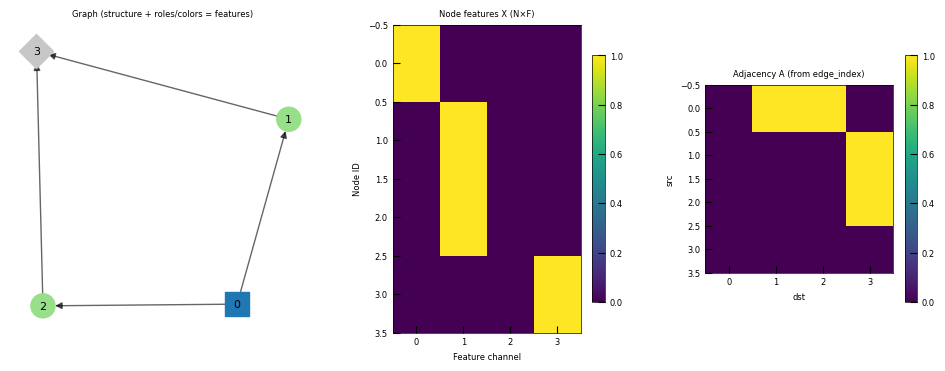

In [ ]:
import torch
import matplotlib.pyplot as plt
import networkx as nx

def visualize_gat_input(edge_index: torch.LongTensor,
                        x: torch.Tensor,
                        node_roles=None,    # list[str] like ["IN","GATE","OUT"] per node (optional)
                        edge_attr=None):    # optional [E, ...]
    """
    edge_index: [2, E] long
    x:          [N, F] float/bool
    """

    N, F = x.shape
    E = edge_index.size(1)

    # ---- Build NX graph for layout/plot ----
    G = nx.DiGraph()
    G.add_nodes_from(range(N))
    edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
    G.add_edges_from(edges)

    # node colors by feature argmax (works well for one-hot)
    node_colors = torch.argmax(x, dim=1).tolist() if F > 1 else x.squeeze().tolist()

    # role → shape mapping (optional)
    role_to_shape = {"IN":"s", "GATE":"o", "OUT":"D"}
    node_shapes = {n: (role_to_shape.get(node_roles[n], "o") if node_roles else "o") for n in range(N)}

    # adjacency for heatmap
    A = torch.zeros(N, N, dtype=torch.float32)
    A[edge_index[0], edge_index[1]] = 1.0

    # ---- Figure with 3 panels ----
    fig = plt.figure(figsize=(12, 4))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.3, 1, 1], wspace=0.3)

    # (1) Graph
    ax0 = fig.add_subplot(gs[0, 0])
    pos = nx.spring_layout(G, seed=42)
    # draw nodes by shape groups for clean legends
    for shape in set(node_shapes.values()):
        nodes = [n for n in G.nodes if node_shapes[n] == shape]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape=shape,
                               node_color=[node_colors[n] for n in nodes],
                               cmap="tab20", vmin=0, vmax=max(node_colors)+1,
                               node_size=300, ax=ax0)
    nx.draw_networkx_edges(G, pos, arrows=True, width=1.0, alpha=0.6, ax=ax0)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax0)
    ax0.set_title("Graph (structure + roles/colors = features)")
    ax0.axis("off")

    # (2) Node feature matrix X
    ax1 = fig.add_subplot(gs[0, 1])
    im1 = ax1.imshow(x.detach().cpu(), aspect="auto")
    ax1.set_xlabel("Feature channel")
    ax1.set_ylabel("Node ID")
    ax1.set_title("Node features X (N×F)")
    fig.colorbar(im1, ax=ax1, shrink=0.8)

    # (3) Adjacency
    ax2 = fig.add_subplot(gs[0, 2])
    im2 = ax2.imshow(A, aspect="equal")
    ax2.set_xlabel("dst")
    ax2.set_ylabel("src")
    ax2.set_title("Adjacency A (from edge_index)")
    fig.colorbar(im2, ax=ax2, shrink=0.8)

    plt.tight_layout()
    plt.show()
    
edge_index = torch.tensor([[0,0,1,2],
                           [1,2,3,3]])           # 0→1, 0→2, 1→3, 2→3
x = torch.tensor([[1,0,0,0],                     # one-hot 4 features
                  [0,1,0,0],
                  [0,1,0,0],
                  [0,0,0,1]], dtype=torch.float)

node_roles = ["IN","GATE","GATE","OUT"]
visualize_gat_input(edge_index, x, node_roles=node_roles)